In [ ]:
%cd /content/
!rm -rf *

/content


This code cell is just a dry implementation of EMD, I do not work with it for the article I use EMD python package for additional options and stability.

In [ ]:
from scipy import signal, interpolate as interp
import numpy as np

def sd_stop(proto_imf, prev_imf, sd=0.2, th=10**-9):
    metric = np.sum((proto_imf - prev_imf)**2) / np.sum(proto_imf**2)

    stop = metric < sd
    if np.sum(proto_imf**2) < th:
        stop = True
    return stop, metric


def get_next_imf(X, env_step_size=1, sd_thresh=.1):

    envelope_opts = {}

    proto_imf = X.copy()

    continue_imf = True
    continue_flag = True
    niters = 0
    while continue_imf:
        niters += 1

        avg = interp_envelope(proto_imf, **envelope_opts)
        if avg is None or not avg.size:
            avg = proto_imf

        x1 = proto_imf - avg

        stop, _ = sd_stop(proto_imf, x1, sd=sd_thresh)

        if stop:
            proto_imf = x1.copy()
            continue_imf = False
            continue

        proto_imf = proto_imf - (env_step_size*avg)

    return proto_imf, continue_flag


def interp_envelope(X):

    extrema_opts = {'pad_width': 2,
                    'loc_pad_opts': None,
                    'mag_pad_opts': None}

    locs, pks = get_padded_extrema(X, **extrema_opts)

    if locs is None:
        return locs
    t = np.arange(locs[0], locs[-1])
    f = interp.splrep(locs, pks)
    if not t.size:
        t = np.arange(1)
    env = interp.splev(t, f)

    t_max = np.arange(locs[0], locs[-1])
    tinds = np.logical_and((t_max >= 0), (t_max < X.shape[0]))

    env = np.array(env[tinds])

    return env



def get_padded_extrema(X, pad_width=2, loc_pad_opts=None, mag_pad_opts=None):
    loc_pad_opts = {'mode': 'reflect', 'reflect_type': 'odd'}
    loc_pad_mode = loc_pad_opts.pop('mode')

    mag_pad_opts = {'mode': 'median', 'stat_length': 1}
    mag_pad_mode = mag_pad_opts.pop('mode')

    if X.ndim == 2:
        X = X[:, 0]

    max_locs, max_ext = _find_extrema(X)

    if not max_locs.size:
        return None, None

    ret_max_locs = np.pad(max_locs, pad_width, loc_pad_mode, **loc_pad_opts)

    ret_max_ext = np.pad(max_ext, pad_width, mag_pad_mode, **mag_pad_opts)

    return ret_max_locs, ret_max_ext


def _find_extrema(X):

    ext_locs = signal.argrelextrema(X, np.greater, order=1)[0]
    return ext_locs, X[ext_locs]



def sift(X, sift_thresh=1e-8):

    imf_opts = {'env_step_size': 1,
                'sd_thresh': .1}

    continue_sift = True
    layer = 0

    proto_imf = X.copy()

    while continue_sift:

        next_imf, continue_sift = get_next_imf(proto_imf,
                                               **imf_opts)

        if layer == 0:
            imf = next_imf
        else:
            imf = np.concatenate((imf, next_imf[0]), axis=0)

        proto_imf = X - imf[:, None]
        layer += 1


        if np.abs(next_imf).sum() < sift_thresh or np.abs(proto_imf).sum() < sift_thresh:
            continue_sift = False

    return imf

sift(np.sin(range(10)))

In [ ]:
%%capture
!pip install emd

In [ ]:
%%capture
!pip install fbm

In [ ]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle
%env KAGGLE_USERNAME=entrack
%env KAGGLE_KEY=d22720ff721300b583367d56910d4bb4

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=1C1wbAuNxMqdcMAPC1PUy4xMgqQix3Hti

In [ ]:
%%capture
!kaggle datasets download -f temperature.csv selfishgene/historical-hourly-weather-data
!unzip temperature.csv.zip
!rm temperature.csv.zip

In [ ]:
H_to_params = {
    0.2: {
        "beta": 0.487,
        'a': 0.452,
        'b': -1.951,
    },
    0.5: {
        "beta": 0.719,
        'a': 0.460,
        'b': -1.919,
    },
    0.8: {
        "beta": 1.025,
        'a': 0.495,
        'b': -1.833,
    },
}

In [ ]:
import emd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set()

custom_grey = [0.15] * 3

In [ ]:
#@title Choose signal
name = "sample" #@param ["sample", "laser_acf", "temperature"]

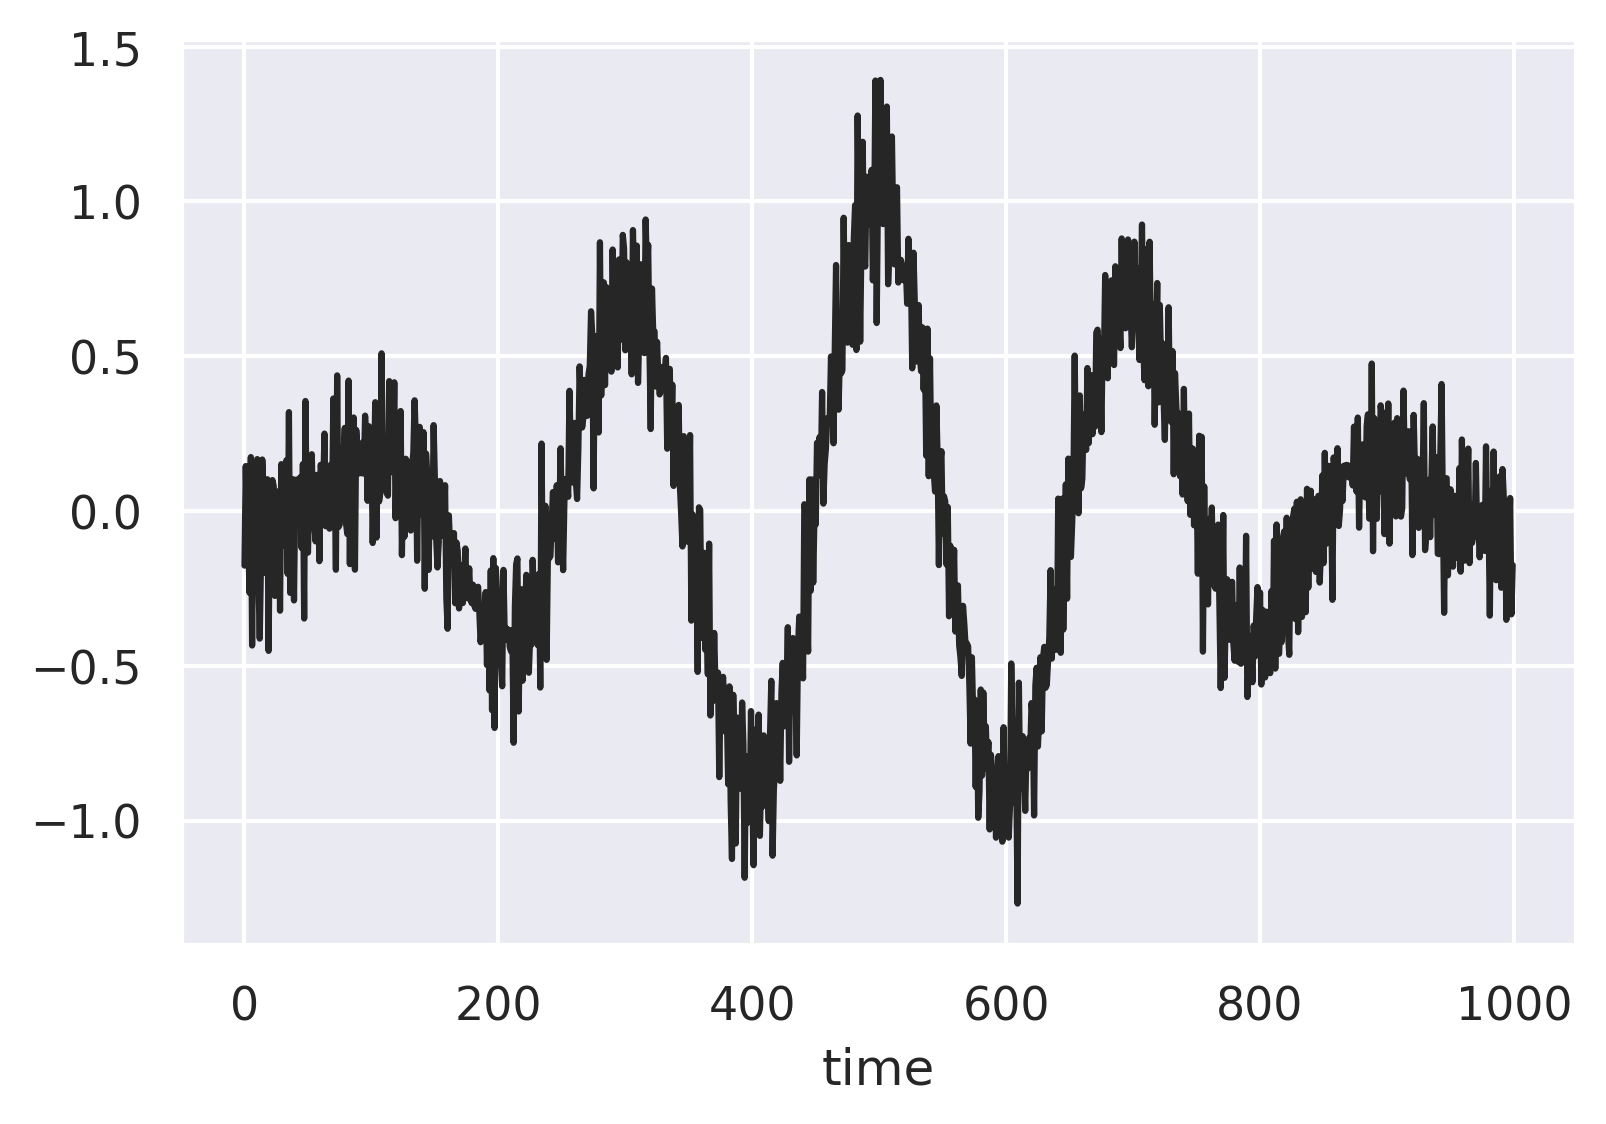

In [ ]:
if name == "sample":
    from scipy.signal import hamming as window
    length = 1000
    x = np.arange(length) - length // 2

    window_signal = window(length)
    signal = np.cos(x / (16 / 500 * length)) * window_signal

    from fbm import FBM

    H = 0.2

    f = FBM(n=x.shape[0], hurst=H)
    noise = f.fgn()
    noise = noise / noise.std()

    noise_level = 0.15
    noise = noise * noise_level
    signal_noisy = signal + noise

    plt.plot(signal_noisy, c=custom_grey)
    plt.xlabel("time")
    plt.savefig(f"{name}_signal.png")
    plt.savefig(f"transparent_{name}_signal.png", transparent=True)

elif name == "laser_acf":
    H = 0.5
    signal_noisy = np.genfromtxt("laser_acf.csv", delimiter=',')[:, 1]
    noise = None
    signal = None

    plt.plot(signal_noisy, c=custom_grey)
    plt.xlabel("time")
    plt.savefig(f"{name}_signal.png")
    plt.savefig(f"transparent_{name}_signal.png", transparent=True)

elif name == "temperature":
    df = pd.read_csv("temperature.csv")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.interpolate(method='nearest').dropna()

    df_hour = df.resample("1H", on="datetime").mean()['Portland'][1:-2]
    df_day = df.resample("1D", on="datetime").mean()['Portland'][1:-2]
    df_week = df.resample("2W", on="datetime").mean()['Portland'][1:-2]

    signal_noisy = df_day.to_numpy()
    noise = None

    import scipy.interpolate as interp
    x = np.linspace(0, 1, num=df_week.shape[0])
    x_new = np.linspace(0, 1, num=signal_noisy.shape[0])
    y = df_week.to_numpy()
    interpolation = interp.interp1d(x, y)
    signal = interpolation(x_new)
    tmp_df = df_day.copy()
    tmp_df[:] = signal
    signal = tmp_df

    H = 0.8

    plt.plot(df_hour, label="hour", alpha=0.75, color="lightsteelblue")
    plt.plot(df_day, label="day", alpha=0.75, color="cornflowerblue")
    plt.plot(df_week, label="week", alpha=0.75, color="royalblue")
    plt.xlabel("time")
    plt.ylabel("fahrenheit")
    plt.legend(fontsize="x-small")
    plt.savefig(f"{name}_signal.png")
    plt.savefig(f"transparent_{name}_signal.png", transparent=True)

In [ ]:
SMALL_SIZE = 8
plt.rc('ytick', labelsize=SMALL_SIZE)

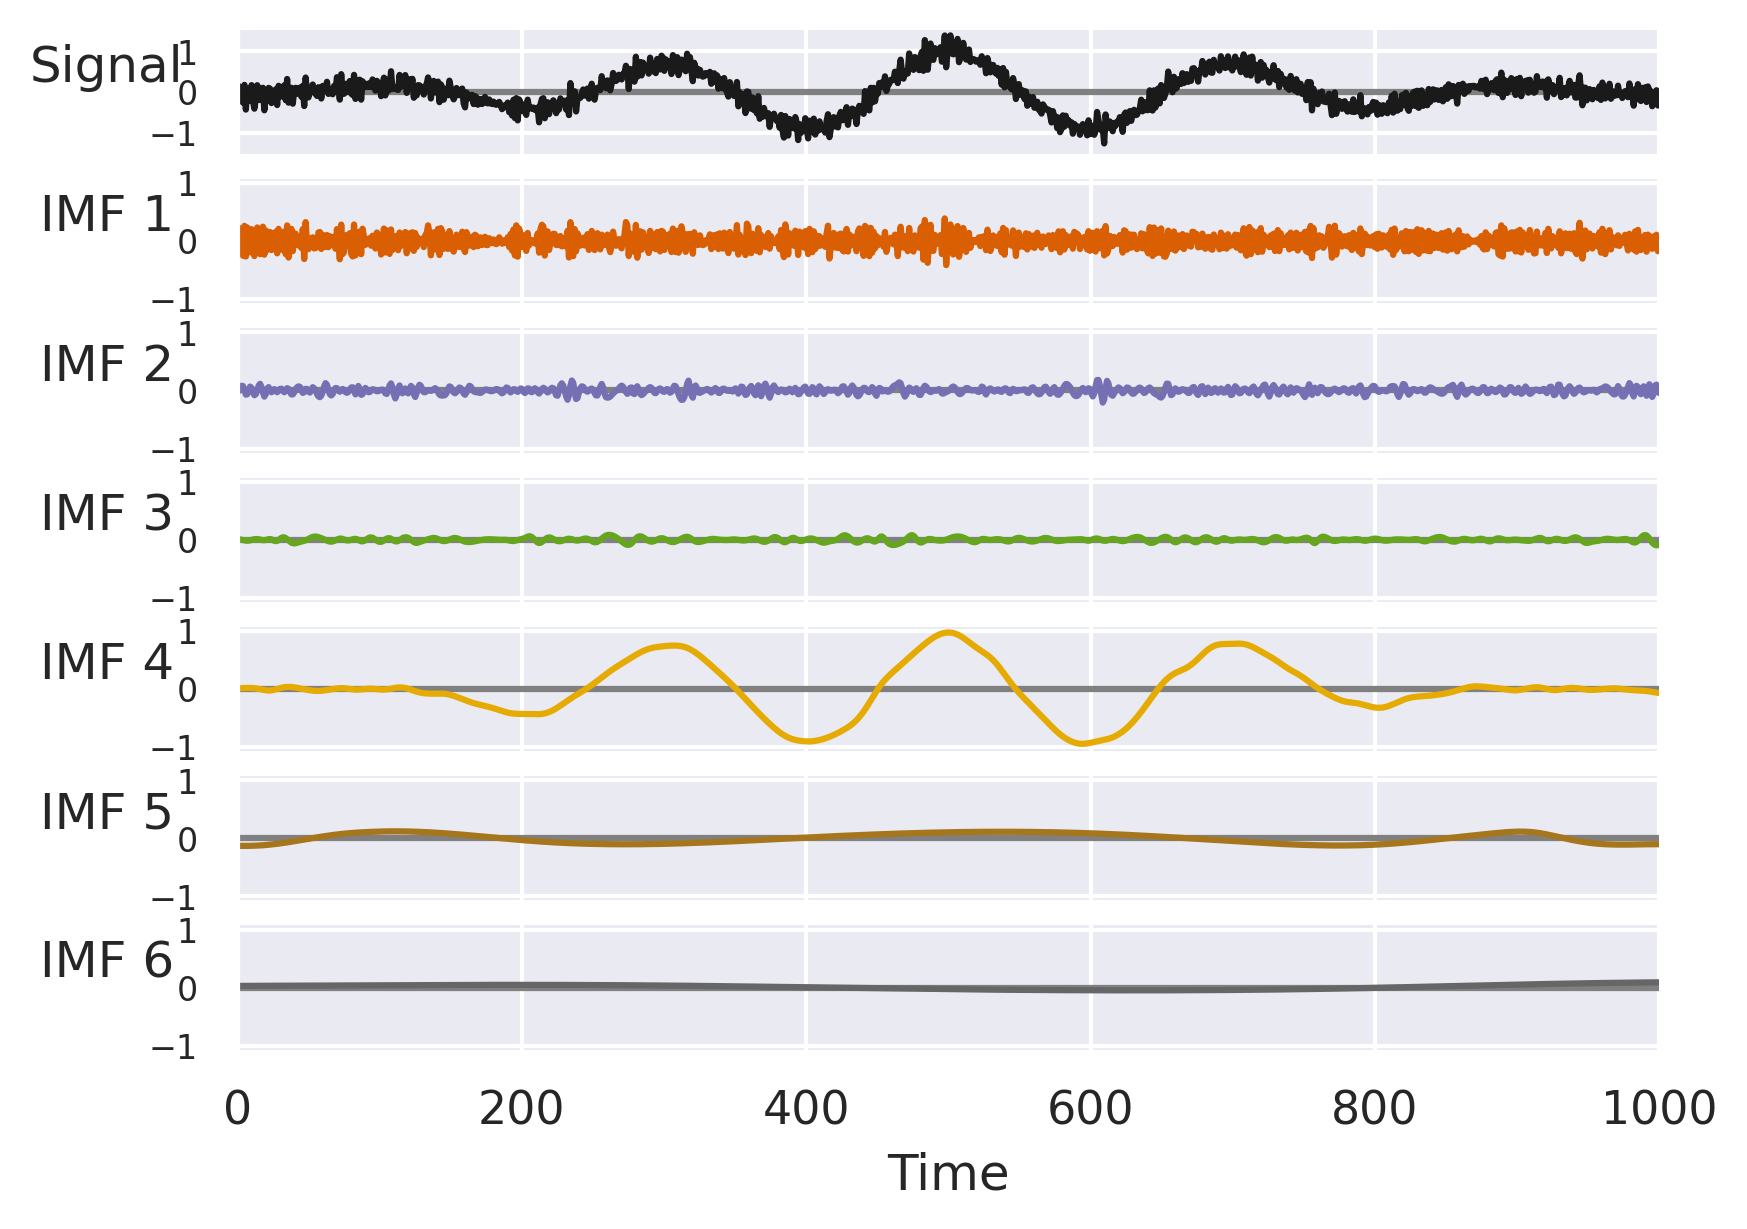

In [ ]:
imf_noisy = emd.sift.sift(signal_noisy)

scale_y = True
if name == "temperature":
    scale_y = False
emd.plotting.plot_imfs(imf_noisy, scale_y=scale_y, cmap=True)

plt.savefig(f"{name}_emd.png")
plt.savefig(f"transparent_{name}_emd.png", transparent=True)

In [ ]:
DEFAULT_SIZE = 11
plt.rc('ytick', labelsize=DEFAULT_SIZE)

In [ ]:
energies_noisy = np.array(
    [np.power(el, 2).sum() for el in imf_noisy.T]) / imf_noisy.shape[0]

In [ ]:
beta = H_to_params[H]['beta']
rho = 2

model_noisy = np.array(
    [energies_noisy[0]] 
    + [(energies_noisy[0] / beta) * np.power(rho, -2 * (1 - H) * k)
for k in range(1, energies_noisy.shape[0])
])

In [ ]:
a = H_to_params[H]['a']
b = H_to_params[H]['b']

model_noisy_interval = np.array(
    [ np.exp(np.exp(a * k + b))
    for k in range(energies_noisy.shape[0])]
) * model_noisy

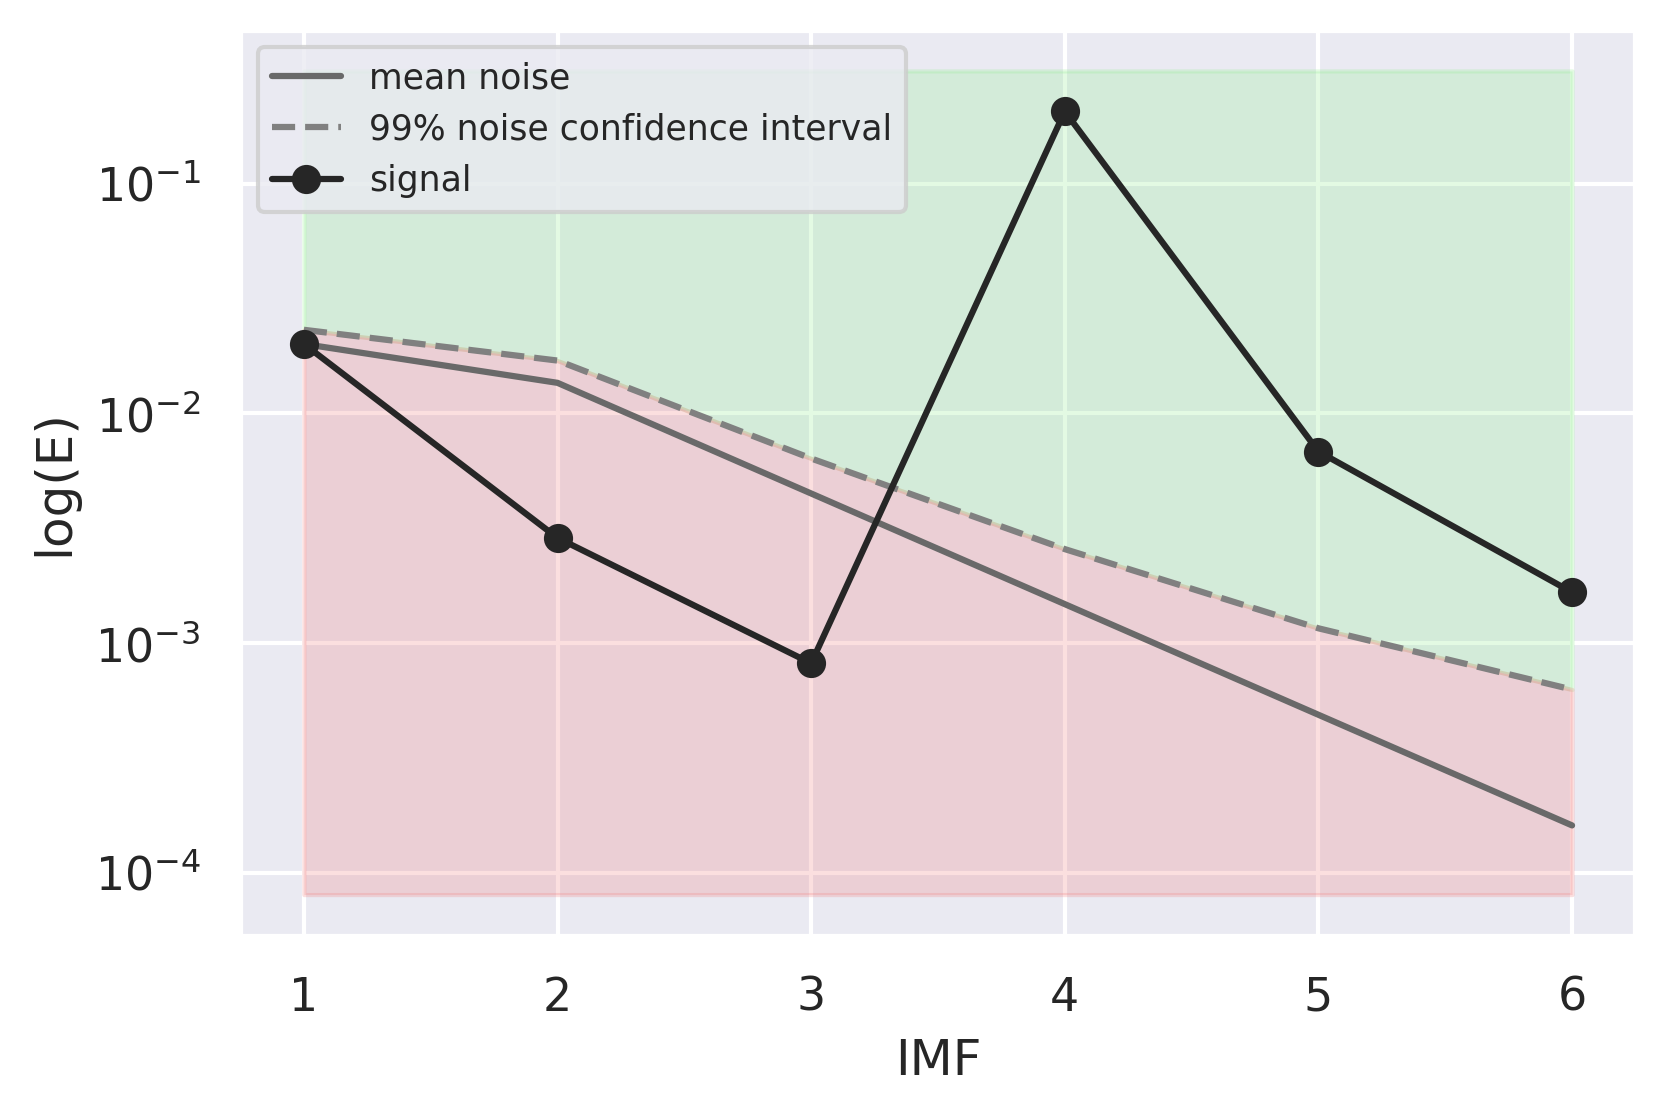

In [ ]:
imf_x = range(1, model_noisy.shape[0] + 1)

plt.plot(imf_x, 
         model_noisy, 
         label="mean noise",
         color="dimgrey",
)
plt.plot(imf_x, 
         model_noisy_interval, 
         label="99% noise confidence interval",
         linestyle='dashed',
         color="grey"
)
plt.plot(imf_x, 
         energies_noisy, 
         label="signal",
         marker='o',
         c=custom_grey,
)

plt.fill_between(imf_x,
                model_noisy_interval,
                energies_noisy.max() + 5e-1 * energies_noisy.max(),
                color='lightgreen',
                alpha=0.25,
)
plt.fill_between(imf_x,
                model_noisy_interval,
                model_noisy.min() - 5e-1 * model_noisy.min(),
                color='lightcoral',
                alpha=0.25,
)

plt.legend(fontsize="x-small")
plt.xlabel("IMF")
plt.ylabel("log(E)")
plt.yscale("log")

plt.savefig(f"{name}_log_E.png")
plt.savefig(f"transparent_{name}_log_E.png", transparent=True)

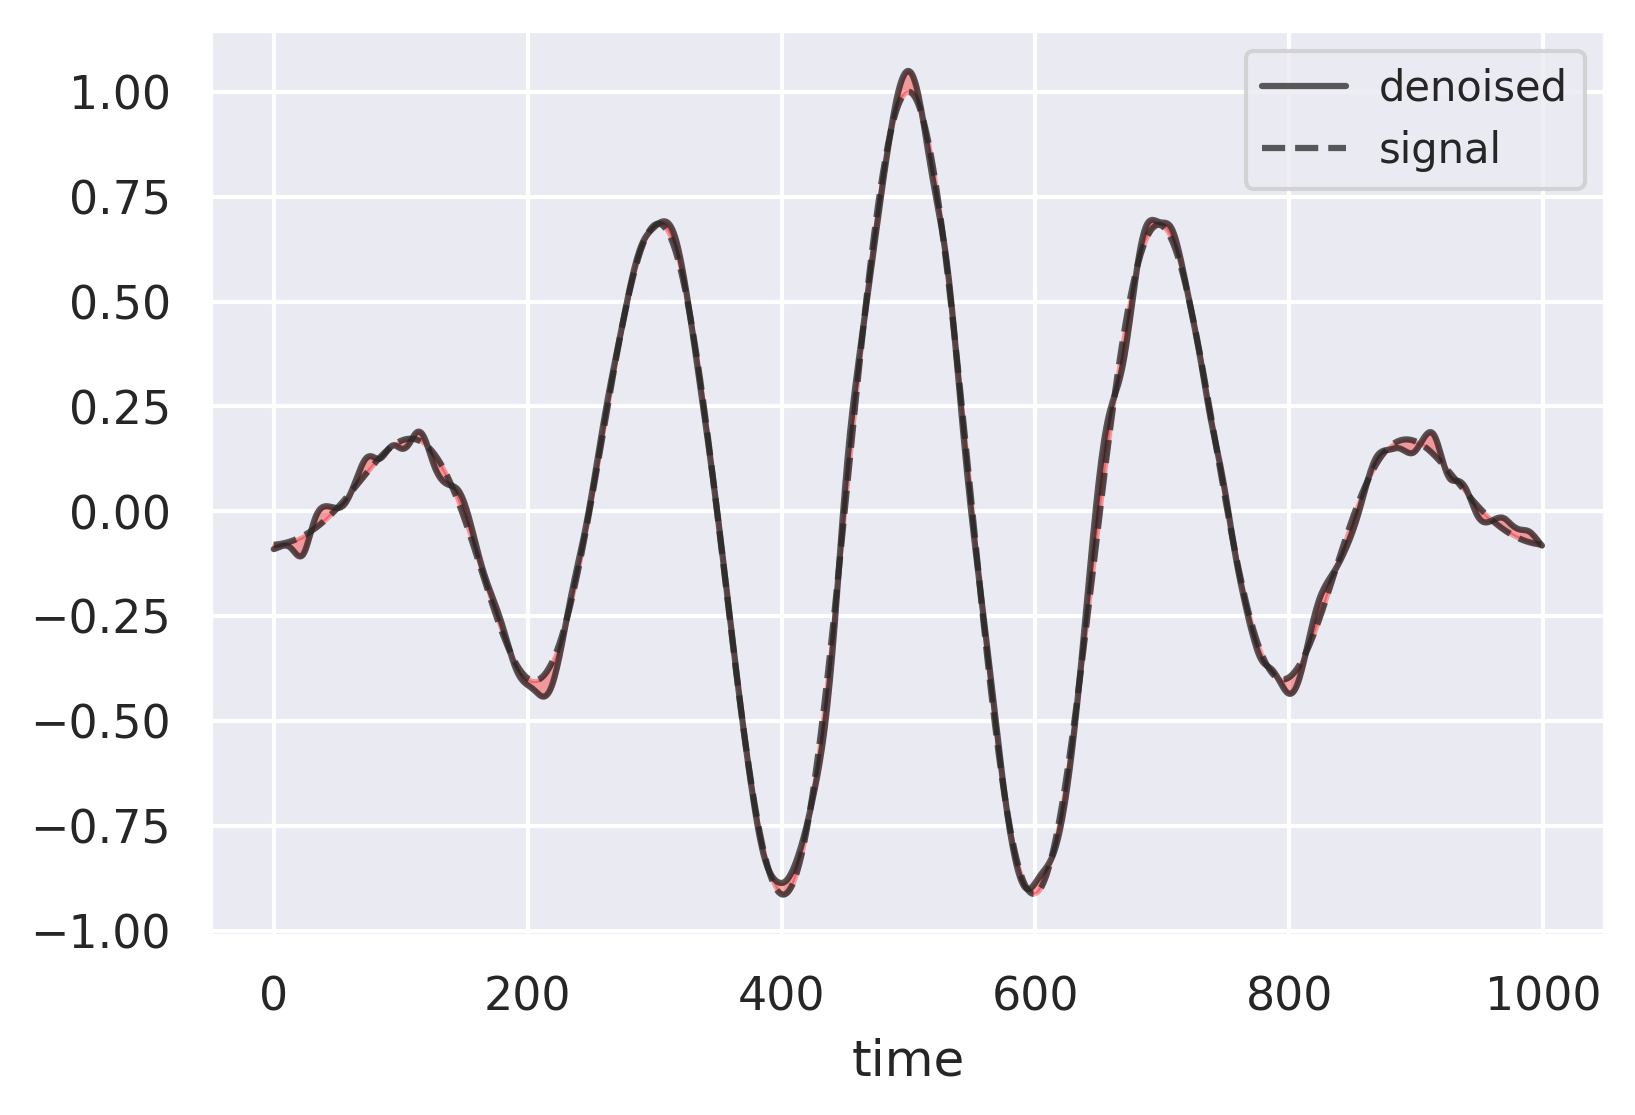

In [ ]:
denoised = imf_noisy[:, energies_noisy > model_noisy_interval].sum(axis=1)
if name == "temperature":
    tmp_df = df_day.copy()
    tmp_df[:] = denoised
    denoised = tmp_df
    plt.ylabel("fahrenheit")

plt.plot(denoised, 
        label="denoised",
        color=custom_grey,
        alpha = 0.75,
)
if not signal is None:
    plt.plot(signal, 
             label="signal",
             color=custom_grey,
             linestyle='dashed',
             alpha = 0.75,
    )

    if isinstance(denoised, np.ndarray):
        plt.fill_between(np.arange(signal.shape[0]),
                        denoised,
                        signal,
                        color='red',
                        alpha=0.35,
        )

plt.legend(fontsize="small")
plt.xlabel("time")

plt.savefig(f"{name}_denoised.png")
plt.savefig(f"transparent_{name}_denoised.png", transparent=True)

In [ ]:
detrended = imf_noisy[:, energies_noisy < model_noisy_interval].sum(axis=1)

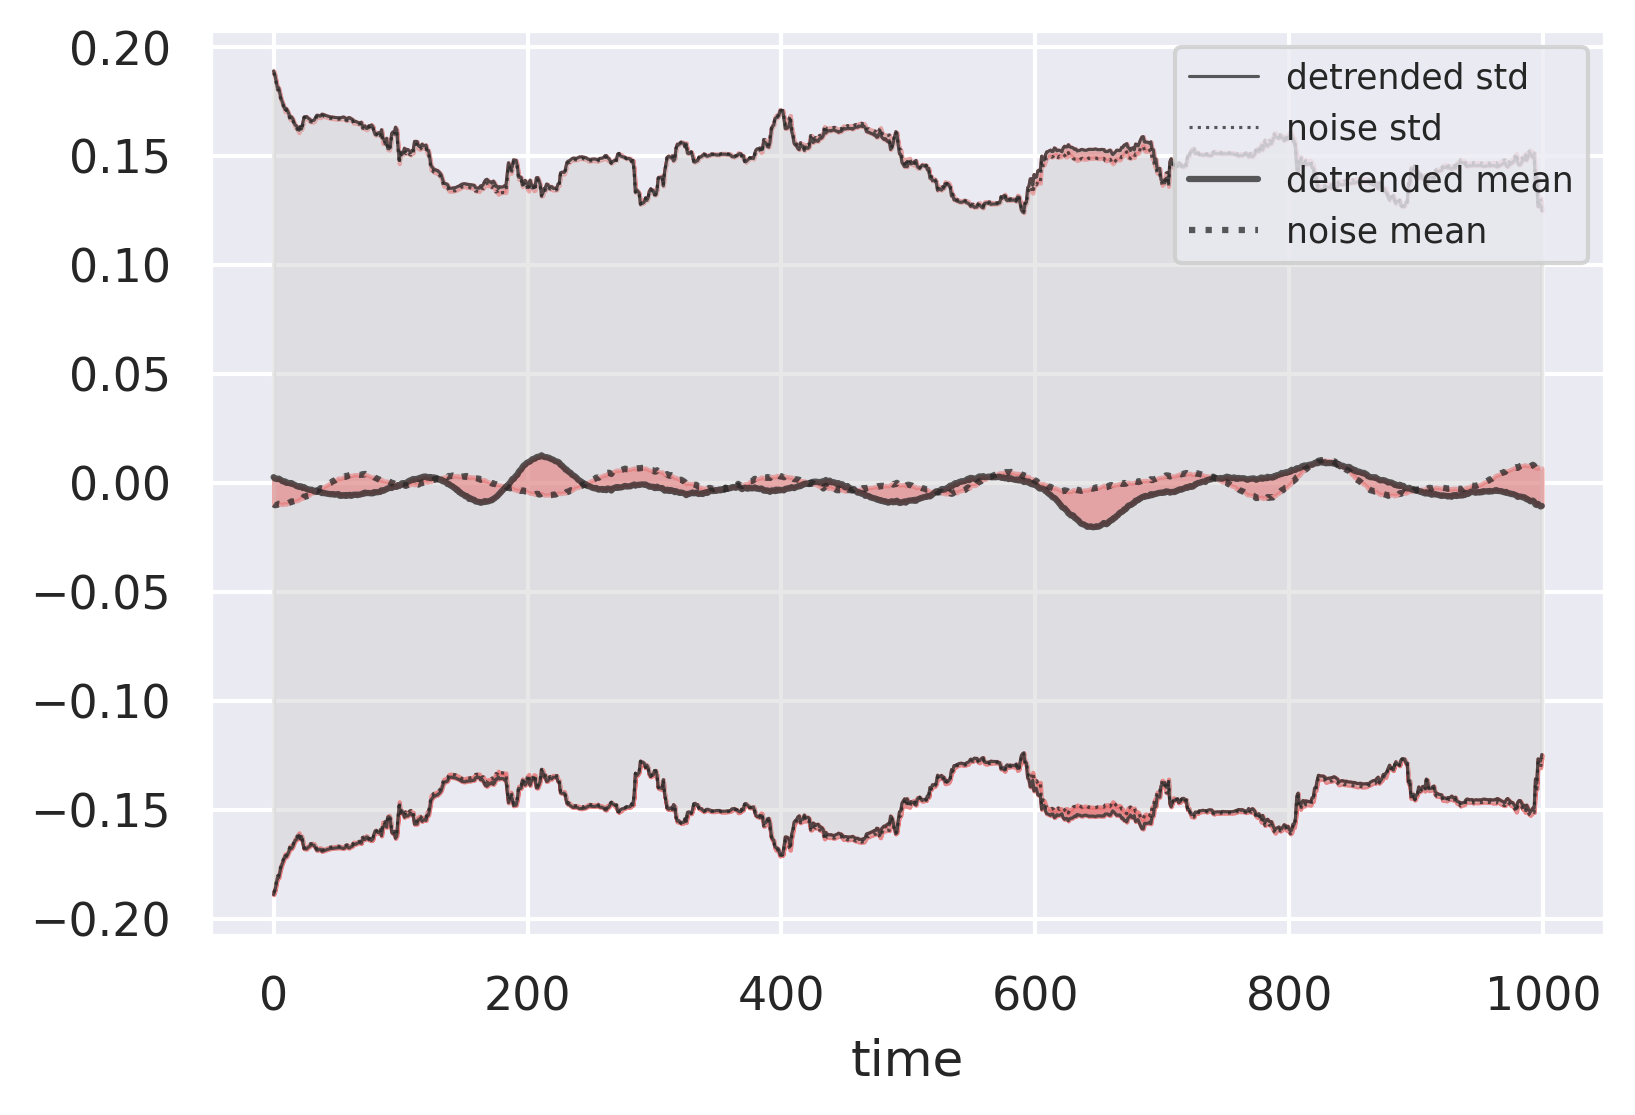

In [ ]:
if not noise is None:
    import pandas as pd

    rolling_window_size = 100

    std_detrended = pd.Series(detrended).rolling(
        rolling_window_size, 
        min_periods=rolling_window_size // 2, 
        center=True, win_type="hamming").std()

    std_noise = pd.Series(noise).rolling(
        rolling_window_size, 
        min_periods=rolling_window_size // 2, 
        center=True, win_type="hamming").std()

    plt.plot(std_detrended,
            color=custom_grey,
            alpha=0.75,
            label="detrended std",
            linewidth=0.75,
    )
    plt.plot(-std_detrended,
            color=custom_grey,
            alpha=0.75,
            linewidth=0.75,
    )

    plt.plot(std_noise,
            color=custom_grey,
            linestyle="dotted",
            alpha=0.75,
            linewidth=0.75,
            label="noise std",
    )
    plt.plot(-std_noise,
            color=custom_grey,
            linestyle="dotted",
            alpha=0.75,
            linewidth=0.75,
    )


    mean_detrended = pd.Series(detrended).rolling(
        rolling_window_size, 
        min_periods=rolling_window_size // 2, 
        center=True, win_type="hamming").mean()

    mean_noise = pd.Series(noise).rolling(
        rolling_window_size, 
        min_periods=rolling_window_size // 2, 
        center=True, win_type="hamming").mean()

    plt.plot(mean_detrended,
            color=custom_grey,
            alpha=0.75,
            label="detrended mean",
    )

    plt.plot(mean_noise,
            color=custom_grey,
            alpha=0.75,
            label="noise mean",
            linestyle="dotted",
    )

    plt.fill_between(np.arange(signal.shape[0]),
                    std_detrended,
                    std_noise,
                    color='red',
                    alpha=0.5,
    )

    plt.fill_between(np.arange(signal.shape[0]),
                    -std_detrended,
                    -std_noise,
                    color='red',
                    alpha=0.75,
    )

    plt.fill_between(np.arange(signal.shape[0]),
                    mean_detrended,
                    mean_noise,
                    color='red',
                    alpha=0.5,
    )

    plt.fill_between(np.arange(signal.shape[0]),
                    np.maximum(std_detrended, std_noise),
                    np.minimum(-std_detrended, -std_noise),
                    color='lightgrey',
                    alpha=0.5,
    )

    plt.legend(fontsize="x-small")
    plt.xlabel("time")

    plt.savefig(f"{name}_detrended.png")
    plt.savefig(f"transparent_{name}_detrended.png", transparent=True)

In [ ]:
!zip "$name".zip *"$name"*.png

  adding: sample_denoised.png (deflated 5%)
  adding: sample_detrended.png (deflated 5%)
  adding: sample_emd.png (deflated 7%)
  adding: sample_log_E.png (deflated 7%)
  adding: sample_signal.png (deflated 8%)
  adding: transparent_sample_denoised.png (deflated 5%)
  adding: transparent_sample_detrended.png (deflated 4%)
  adding: transparent_sample_emd.png (deflated 7%)
  adding: transparent_sample_log_E.png (deflated 6%)
  adding: transparent_sample_signal.png (deflated 8%)
